In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from prometheus_api_client import PrometheusConnect
from math import sqrt
import datetime

In [35]:
PROMETHEUS_URL = 'http://localhost:9090'
PROMETHEUS_ACCESS_TOKEN = ''  

# Initialize Prometheus connection
prom = PrometheusConnect(url=PROMETHEUS_URL, disable_ssl=True)

# Queries
ram_query = '100 - ((avg_over_time(node_memory_MemAvailable_bytes{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s]) * 100) / avg_over_time(node_memory_MemTotal_bytes{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s]))'
cpu_query = '(sum by(instance) (irate(node_cpu_seconds_total{instance="172.16.101.106:9100",job="kubernetes-service-endpoints", mode!="idle"}[5m15s])) / on(instance) group_left sum by (instance)((irate(node_cpu_seconds_total{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s])))) * 100'

In [32]:
def predict(
    prom,
    query,
    name="value",
    start_days_ago=7,
    step="3000",
    look_back=3,
    epochs=1000,
    batch_size=1,
    patience=10,
    degree=0.0005
):
    end_time = datetime.datetime.now()
    start_time = end_time - datetime.timedelta(days=start_days_ago)

    data = prom.custom_query_range(
        query=query, start_time=start_time, end_time=end_time, step=step
    )

    if data:
        timestamps = [
            datetime.datetime.fromtimestamp(float(item[0]))
            for item in data[0]["values"]
        ]
        value = [float(item[1]) for item in data[0]["values"]]

        df = pd.DataFrame(data={"timestamp": timestamps, name: value})
        df["timestamp"] = pd.to_datetime(df["timestamp"])

        # Normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_cpu_usage = scaler.fit_transform(df[name].values.reshape(-1, 1))

        # Convert an array of values into a dataset matrix
        def create_dataset(dataset, look_back=3):
            dataX, dataY = [], []
            for i in range(len(dataset) - look_back - 1):
                a = dataset[i : (i + look_back), 0]
                dataX.append(a)
                dataY.append(dataset[i + look_back, 0])
            return np.array(dataX), np.array(dataY)

        train_size = int(len(scaled_cpu_usage) * 0.67)
        test_size = len(scaled_cpu_usage) - train_size
        train, test = (
            scaled_cpu_usage[0:train_size, :],
            scaled_cpu_usage[train_size : len(scaled_cpu_usage), :],
        )

        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(50, input_shape=(1, look_back), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(25, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss="mean_squared_error", optimizer=Adam(degree))

        # Fit the model with early stopping
        early_stop = EarlyStopping(monitor="val_loss", patience=patience, verbose=1)
        history = model.fit(
            trainX,
            trainY,
            epochs=epochs,
            batch_size=batch_size,
            verbose=2,
            validation_data=(testX, testY),
            callbacks=[early_stop],
        )

        # Predictions for training and testing dataset
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # Invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])

        # Calculate RMSE
        trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
        testScore = sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
        print("Train Score: %.2f RMSE" % (trainScore))
        print("Test Score: %.2f RMSE" % (testScore))

        # Visualization
        plt.figure(figsize=(15, 6))
        plt.plot(df["timestamp"], df[name], label="Original Data")
        plt.plot(
            df["timestamp"],
            np.pad(
                trainPredict.ravel(),
                (look_back, len(df) - len(trainPredict) - look_back),
                "constant",
                constant_values=np.nan,
            ),
            label="Train Prediction",
        )
        plt.plot(
            df["timestamp"],
            np.pad(
                testPredict.ravel(),
                (
                    len(trainPredict) + 2 * look_back + 1,
                    len(df) - len(testPredict) - len(trainPredict) - 2 * look_back - 1,
                ),
                "constant",
                constant_values=np.nan,
            ),
            label="Test Prediction",
        )
        plt.title(f"{name} Prediction")
        plt.xlabel("Timestamp")
        plt.ylabel(name)
        plt.legend()
        plt.show()
    else:
        print("No data returned from Prometheus or unexpected data format.")

Epoch 1/1000


/Users/william/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 - 3s - 26ms/step - loss: 0.1378 - val_loss: 0.0743
Epoch 2/1000
131/131 - 0s - 2ms/step - loss: 0.0360 - val_loss: 0.0285
Epoch 3/1000
131/131 - 0s - 2ms/step - loss: 0.0230 - val_loss: 0.0284
Epoch 4/1000
131/131 - 0s - 2ms/step - loss: 0.0205 - val_loss: 0.0301
Epoch 5/1000
131/131 - 0s - 2ms/step - loss: 0.0224 - val_loss: 0.0333
Epoch 6/1000
131/131 - 0s - 2ms/step - loss: 0.0196 - val_loss: 0.0314
Epoch 7/1000
131/131 - 0s - 2ms/step - loss: 0.0141 - val_loss: 0.0302
Epoch 8/1000
131/131 - 0s - 2ms/step - loss: 0.0178 - val_loss: 0.0315
Epoch 9/1000
131/131 - 0s - 2ms/step - loss: 0.0153 - val_loss: 0.0313
Epoch 10/1000
131/131 - 0s - 2ms/step - loss: 0.0162 - val_loss: 0.0336
Epoch 11/1000
131/131 - 0s - 2ms/step - loss: 0.0180 - val_loss: 0.0311
Epoch 12/1000
131/131 - 0s - 2ms/step - loss: 0.0167 - val_loss: 0.0351
Epoch 13/1000
131/131 - 0s - 2ms/step - loss: 0.0183 - val_loss: 0.0331
Epoch 14/1000
131/131 - 0s - 2ms/step - loss: 0.0173 - val_loss: 0.0330
Epoch 15/1000

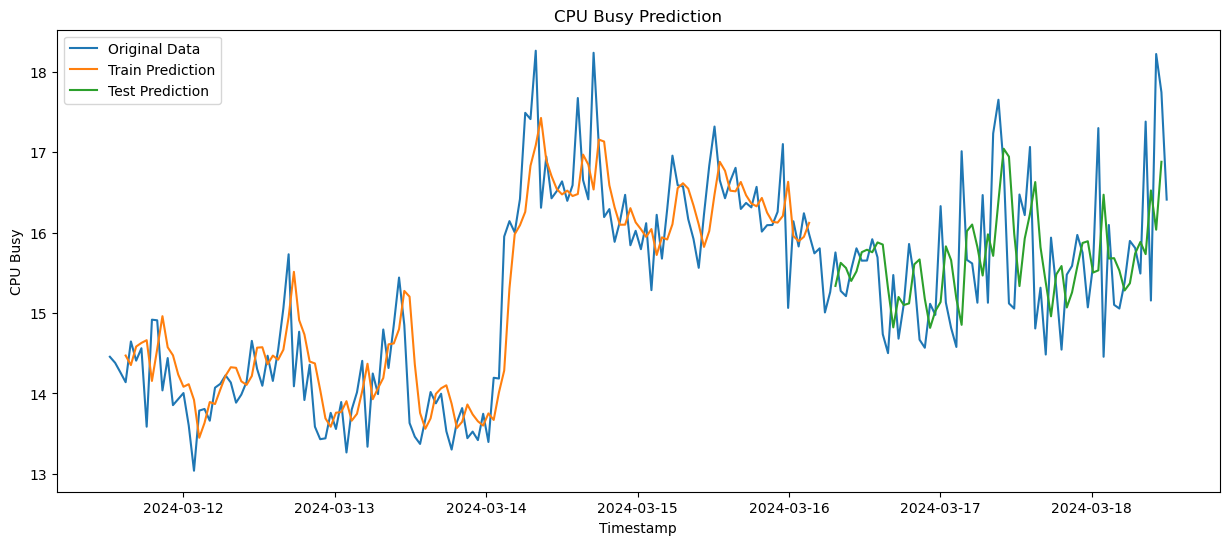

In [38]:
predict(prom, query, name="CPU Busy", patience=100)

Epoch 1/1000


/Users/william/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 - 3s - 24ms/step - loss: 0.0873 - val_loss: 0.0942
Epoch 2/1000
131/131 - 0s - 2ms/step - loss: 0.0092 - val_loss: 0.0251
Epoch 3/1000
131/131 - 0s - 2ms/step - loss: 0.0082 - val_loss: 0.0374
Epoch 4/1000
131/131 - 0s - 2ms/step - loss: 0.0079 - val_loss: 0.0203
Epoch 5/1000
131/131 - 0s - 2ms/step - loss: 0.0069 - val_loss: 0.0167
Epoch 6/1000
131/131 - 0s - 2ms/step - loss: 0.0071 - val_loss: 0.0043
Epoch 7/1000
131/131 - 0s - 2ms/step - loss: 0.0067 - val_loss: 0.0031
Epoch 8/1000
131/131 - 0s - 2ms/step - loss: 0.0059 - val_loss: 0.0017
Epoch 9/1000
131/131 - 0s - 2ms/step - loss: 0.0059 - val_loss: 6.9629e-04
Epoch 10/1000
131/131 - 0s - 2ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 11/1000
131/131 - 0s - 2ms/step - loss: 0.0065 - val_loss: 0.0011
Epoch 12/1000
131/131 - 0s - 2ms/step - loss: 0.0053 - val_loss: 7.6230e-04
Epoch 13/1000
131/131 - 0s - 2ms/step - loss: 0.0037 - val_loss: 7.8990e-04
Epoch 14/1000
131/131 - 0s - 2ms/step - loss: 0.0044 - val_loss: 0.0013
E

Epoch 114/1000
131/131 - 0s - 2ms/step - loss: 0.0027 - val_loss: 5.7118e-04
Epoch 115/1000
131/131 - 0s - 2ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 116/1000
131/131 - 0s - 2ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 117/1000
131/131 - 0s - 2ms/step - loss: 0.0029 - val_loss: 8.3668e-04
Epoch 118/1000
131/131 - 0s - 2ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 119/1000
131/131 - 0s - 2ms/step - loss: 0.0028 - val_loss: 6.5829e-04
Epoch 120/1000
131/131 - 0s - 2ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 121/1000
131/131 - 0s - 2ms/step - loss: 0.0027 - val_loss: 5.5787e-04
Epoch 122/1000
131/131 - 0s - 2ms/step - loss: 0.0028 - val_loss: 7.5340e-04
Epoch 123/1000
131/131 - 0s - 2ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 124/1000
131/131 - 0s - 2ms/step - loss: 0.0030 - val_loss: 5.5017e-04
Epoch 125/1000
131/131 - 0s - 2ms/step - loss: 0.0027 - val_loss: 6.3840e-04
Epoch 126/1000
131/131 - 0s - 2ms/step - loss: 0.0030 - val_loss: 5.9149e-04
Epoch 127/1000
131/

131/131 - 0s - 2ms/step - loss: 0.0026 - val_loss: 5.8886e-04
Epoch 223/1000
131/131 - 0s - 2ms/step - loss: 0.0026 - val_loss: 6.2655e-04
Epoch 224/1000
131/131 - 0s - 2ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 225/1000
131/131 - 0s - 2ms/step - loss: 0.0026 - val_loss: 5.5581e-04
Epoch 226/1000
131/131 - 0s - 2ms/step - loss: 0.0029 - val_loss: 7.8251e-04
Epoch 227/1000
131/131 - 0s - 2ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 228/1000
131/131 - 0s - 2ms/step - loss: 0.0028 - val_loss: 6.1988e-04
Epoch 229/1000
131/131 - 0s - 2ms/step - loss: 0.0027 - val_loss: 6.4513e-04
Epoch 230/1000
131/131 - 0s - 2ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 231/1000
131/131 - 0s - 2ms/step - loss: 0.0026 - val_loss: 6.7083e-04
Epoch 232/1000
131/131 - 0s - 2ms/step - loss: 0.0026 - val_loss: 6.0127e-04
Epoch 233/1000
131/131 - 0s - 2ms/step - loss: 0.0028 - val_loss: 7.3131e-04
Epoch 234/1000
131/131 - 0s - 2ms/step - loss: 0.0027 - val_loss: 8.1020e-04
Epoch 235/1000
131/131 - 0

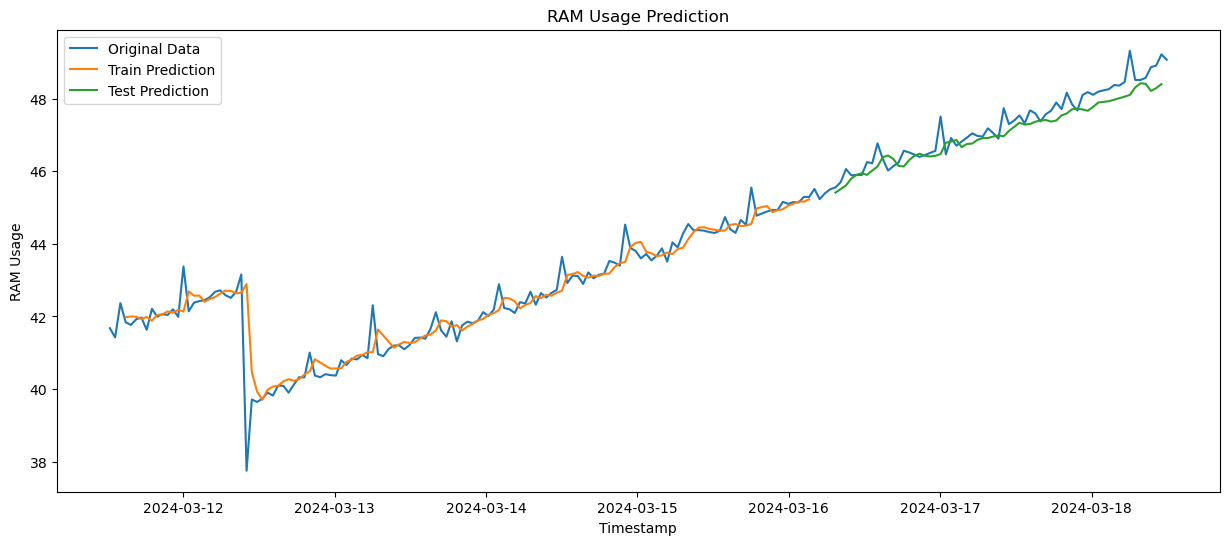

In [39]:
predict(prom, ram_query, name="RAM Usage", patience=100)